## Постановка проблеми

Цей підручник базується на практичному та кодовому підході. Ми визначимо терміни _машинне навчання_ та _лінійна регресія_ в контексті проблеми, а потім узагальнимо їх визначення. Ми пройдемо крок за кроком через типову проблему машинного навчання:


> **ПИТАННЯ**: Компанія ACME Insurance Inc. пропонує доступне медичне страхування тисячам клієнтів по всіх Сполучених Штатах. Як головний дата-сайентіст в ACME, **вам доручено створити автоматизовану систему для оцінки річних медичних витрат для нових клієнтів**, використовуючи інформацію, таку як їх вік, стать, ІМТ, діти, звички щодо куріння та регіон проживання.
>
> Оцінки з вашої системи будуть використовуватися для визначення річної страхової премії (сума, що сплачується щомісяця) пропонованої клієнту. Через регулятивні вимоги, ви повинні мати змогу пояснити, чому ваша система видає певний прогноз.
>
> Вам надано [CSV файл](https://drive.google.com/file/d/13UBFUbkaqccMc4WFHs60tzndCyTOWGE_/view?usp=sharing), що містить перевірені історичні дані, які складаються з вищезгаданої інформації та фактичних медичних витрат, здійснених понад 1300 клієнтами.
> <img src="https://i.imgur.com/87Uw0aG.png" width="480">
>
> Джерело набору даних: https://github.com/stedy/Machine-Learning-with-R-datasets


**ВПРАВА 1**: Перед тим як продовжувати, зупиніться на мить і подумайте, як ви можете підійти до цієї проблеми. Запишіть п'ять або більше ідей, які приходять вам на думку нижче:

 1. Прогнозувати просто всім користувачам певне константне фіксоване значення charges (наприклад, середнє або медіана). Рішення не найкраще, але краще, ніж нічого :)
 2. Прогнозувати для курців середнє значення charges для курців (з наявних даних), а для некурців - відповідне теж середнє значення charges для цих користувачів.
 3. Придумати формулу як обчислити charges відносно віку, наприклад charges = вік * 800 виходяч з аналізу, в скільки разів середня величина charges для кожноъ вікової групи вища за вік.
 4. Прогнозувати для курців середнє значення charges для міксу регіону і факту, чи курить людина - тобто матимемо 8 груп з різними прогнозними значеннями.
 5. Придумати формулу залежності charges і BMI через мультиплікатор (подібно до п.3)

## Завантаження даних

Для початку, давайте завантажимо дані з файлу csv.

In [ ]:
import pandas as pd

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
!ls 'drive/MyDrive/ML Intensive from 0 to Hero'

'1. EDA. Лінійна регресія. Solution.ipynb'   medical-charges.csv


In [ ]:
file_name = 'drive/MyDrive/ML Intensive from 0 to Hero/medical-charges.csv'

In [ ]:
medical_df = pd.read_csv(file_name)

In [ ]:
medical_df

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830
1334,18,female,31.920,0,no,northeast,2205.98080
1335,18,female,36.850,0,no,southeast,1629.83350
1336,21,female,25.800,0,no,southwest,2007.94500


Набір даних містить 1338 рядків та 7 стовпців. Кожен рядок набору даних містить інформацію про одного клієнта.

Наша мета - знайти спосіб оцінки значення в стовпці "charges", використовуючи значення в інших стовпцях. Якщо ми можемо це зробити для історичних даних, то ми повинні змогти оцінити вартість для нових клієнтів, просто запитавши інформацію, таку як їх вік, стать, ІМТ, кількість дітей, звички щодо куріння та регіон.

Давайте перевіримо тип даних для кожного стовпця.

In [ ]:
medical_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


Схоже, що "вік", "діти", "ІМТ" ([індекс маси тіла](https://en.wikipedia.org/wiki/Body_mass_index)) та "платежі" є числами, тоді як "стать", "курець" та "регіон" є рядками (можливо, категоріями). Жоден з стовпців не містить пропущених значень, що економить нам чимало часу!

Про те, як можна заповнювати пропущені дані і чому це варто робити - розповідаю на великому курсі, а для тих, хто хоче розібратись прямо зараз рекомендую [статтю](https://www.analyticsvidhya.com/blog/2021/10/handling-missing-value/) .

Глянемо статистику для числових стовпців:

In [ ]:
medical_df.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


Діапазони значень в числових стовпцях також здаються розумними (немає від'ємного віку!), тому нам може не довестися робити багато очищення даних або корекції. Однак стовпець "charges" здається значно спотвореним, оскільки медіана (50 перцентиль) набагато нижча за максимальне значення.

> **ВПРАВА 2**: Які інші висновки ви можете зробити, переглядаючи таблицю вище? Додайте свої висновки нижче:
>


Виходячи з представлених статистичних даних:

1. **Вік (age)**:
   - Діапазон: 18 - 64 років
   - Середнє значення (mean): 39.21 років
   - Медiана (50%): 39 років
   - Вік виглядає досить рівномірно розподіленим без явних відхилень або екстремальних значень.

2. **Індекс маси тіла (BMI)**:
   - Діапазон: 15.96 - 53.13
   - Середнє значення (mean): 30.66
   - Медiана (50%): 30.40
   - Значення виглядають розподіленими досить рівномірно.

3. **Кількість дітей (children)**:
   - Діапазон: 0 - 5 дітей
   - Середнє значення (mean): 1.09
   - Медiана (50%): 1 дитина
   - Кількість дітей також виглядає адекватною без значних викривлень.

4. **Медичні витрати (charges)**:
   - Діапазон: 1121.87 - 63770.43
   - Середнє значення (mean): 13270.42
   - Медiана (50%): 9382.03
   - Стандартне відхилення (std): 12110.01
   - Тут ми бачимо значний розкид в значеннях медичних витрат. Це може вказувати на наявність високих значень, які значно перевищують середнє та медіанне значення, що може бути пов'язано з дорогими лікуваннями або іншими медичними витратами.

На основі цих даних, можна зробити висновок, що столбці "age", "bmi", та "children" не потребують значної очистки або корекції. Однак, столбец "charges" має значні відхилення, що може вказувати на наявність аномалій або екстремальних значень, які варто дослідити детальніше.

## Дослідницький аналіз та візуалізація з plotly

Давайте дослідимо дані, візуалізуючи розподіл значень у деяких стовпцях набору даних, а також взаємозв'язки між "витратами" та іншими стовпцями.

В машинному навчанні найчастіше використовують бібліотеки Matplotlib, Seaborn та Plotly для візуалізації. І ми теж будемо працювати з ними. Аби отримати інтро про те, як ними користуватись - рекомендую наступні ресурси Ознайомтеся з цими посібниками, щоб дізнатися, як використовувати ці бібліотеки:

- https://matplotlib.org/stable/users/explain/quick_start.html
- https://plotly.com/python/getting-started/

Але навіть якщо ви ніколи не користувались цими існтрументами - це не біда. Просто робіть за мною за аналогією і ви вже будете будувати найнеобхіжніші графіки. А в роботі можете просто потім скопіювати код звідси 😉

Спочатку імпортуємо всі лібки. Зазвичай ми їх імпортуємо саме в такий спосіб, це зручно для подальшого використання.

In [ ]:
import plotly.express as px
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

Наступні налаштування допоможуть покращити стандартний стиль та розміри шрифтів для наших діаграм. Налаштування за замовченням - теж норм. Справа смаку.

In [ ]:
sns.set_style('darkgrid')
matplotlib.rcParams['font.size'] = 14
matplotlib.rcParams['figure.figsize'] = (10, 6)
matplotlib.rcParams['figure.facecolor'] = '#00000000'

### Вік

Вік - це числова колонка. Мінімальний вік в наборі даних - 18 років, а максимальний - 64 роки. Таким чином, ми можемо візуалізувати розподіл віку, використовуючи гістограму з 47 бінами (один на кожен рік) та ящик з вусами. Ми використаємо plotly для створення інтерактивної діаграми, але ви можете створити подібні діаграми, використовуючи Seaborn.

Про те, які бувають графіки і коли який використовувати можна ознайомитись тут:

  https://datavizcatalogue.com/

In [ ]:
medical_df.age.describe()

count    1338.000000
mean       39.207025
std        14.049960
min        18.000000
25%        27.000000
50%        39.000000
75%        51.000000
max        64.000000
Name: age, dtype: float64

In [ ]:
fig = px.histogram(medical_df,
                   x='age',
                   marginal='box',
                   nbins=47,
                   title='Distribution of Age')
fig.update_layout(bargap=0.1)
fig.show()

Розподіл віку в наборі даних майже рівномірний, з 20-30 клієнтами на кожен вік, за винятком 18 та 19 років, де здається, що клієнтів більше ніж у два рази порівняно з іншими віками. Рівномірний розподіл може виникнути через те, що немає великої варіації в [кількості людей певного віку](https://www.statista.com/statistics/241488/population-of-the-us-by-sex-and-age/) (між 18 та 64 роками) в США.

> **ВПРАВА 3**: Чи можете ви пояснити, чому клієнтів віком 18 та 19 років більше ніж у два рази порівняно з іншими віками?
>
>

Може бути кілька можливих причин, чому клієнтів віком 18 та 19 років більше ніж у два рази порівняно з іншими віками в наданому наборі даних:

1. **Політика та маркетинг компанії**:
   - Компанія ACME Insurance Inc. могла проводити активні маркетингові кампанії, націлені на молодих дорослих, особливо тих, хто щойно досяг повноліття і потребує власного страхування. Це могло призвести до збільшення кількості клієнтів у віковій групі 18-19 років.

2. **Демографічні особливості**:
   - У Сполучених Штатах може бути більше людей у віці 18-19 років, які тільки-но починають самостійне життя і, відповідно, шукають медичне страхування. Це може пояснити підвищену кількість клієнтів у цій віковій категорії.

3. **Регулятивні зміни**:
   - Можливо, існують певні регулятивні зміни або пільги, які впливають на медичне страхування для молодих дорослих, що сприяє їх активнішому залученню до страхових програм.

4. **Освітні програми**:
   - Освітні програми чи рекомендації від навчальних закладів або громадських організацій можуть заохочувати молодих дорослих до оформлення медичного страхування одразу після досягнення 18-річного віку.

Щоб точніше відповісти на питання, необхідно мати додаткову інформацію про політику компанії, демографічні дані та інші фактори, які могли б вплинути на розподіл вікових груп у наборі даних.

### Індекс маси тіла

Давайте подивимося на розподіл ІМТ (Індексу маси тіла) клієнтів, використовуючи гістограму та ящик з вусами.

In [ ]:
fig = px.histogram(medical_df,
                   x='bmi',
                   marginal='box',
                   color_discrete_sequence=['red'],
                   title='Distribution of BMI (Body Mass Index)')
fig.update_layout(bargap=0.1)
fig.show()

Вимірювання індексу маси тіла, здається, формують [гауссівський розподіл](https://en.wikipedia.org/wiki/Normal_distribution), центрований навколо значення 30, з кількома викидами вправо. Ось як можна інтерпретувати значення ІМТ ([джерело](https://study.com/academy/lesson/what-is-bmi-definition-formula-calculation.html)):

![](https://i.imgur.com/lh23OiY.jpg)

> **ВПРАВА 4**: Чи можете ви пояснити, чому розподіл віків формує рівномірний розподіл, а розподіл ІМТ формує гауссовий розподіл?
>

- **Рівномірний розподіл віку**: Такий розподіл може бути зумовлений специфікою вибірки, яка охоплює всі вікові групи без явних переваг для будь-якої групи. Це може бути результатом цілеспрямованого відбору даних або особливостей популяції, де всі вікові групи представлені рівномірно.

- **Гауссовий розподіл ІМТ**: ІМТ розподілений за нормальним розподілом через вплив багатьох незалежних змінних. Наприклад, генетичні фактори, спосіб життя, харчування, фізична активність та інші фактори сукупно формують розподіл, який виявляється близьким до нормального. Більшість людей мають ІМТ, близький до середнього значення, а менша кількість людей мають екстремально високі або низькі значення ІМТ.

### Збори

Давайте візуалізуємо розподіл "зборів", тобто річних медичних витрат для клієнтів. Це колонка, яку ми намагаємося передбачити. Також використовуймо категоріальну колонку "курець", щоб відрізнити збори для курців та некурців.

In [ ]:
fig = px.histogram(medical_df,
                   x='charges',
                   marginal='box',
                   color='smoker',
                   color_discrete_sequence=['green', 'grey'],
                   title='Annual Medical Charges')
fig.update_layout(bargap=0.1)
fig.show()

Ми можемо зробити наступні спостереження з вищенаведеного графіку:

* Для більшості клієнтів річні медичні витрати становлять менше \$10,000. Тільки невелика частина клієнтів має вищі медичні витрати, можливо, через нещасні випадки, серйозні хвороби та генетичні захворювання. Розподіл слідує "закону потужності"
* Існує значна різниця в медичних витратах між курцями та некурцями. Тоді як медіана для некурців становить \$7300, медіана для курців наближається до \$35,000.


> **ВПРАВА 5**: Візуалізуйте розподіл медичних витрат у зв'язку з іншими факторами, такими як "стать" та "регіон". Що ви спостерігаєте?

In [ ]:
fig = px.histogram(medical_df,
                   x='charges',
                   marginal='box',
                   color='sex',
                   color_discrete_sequence=['green', 'grey'],
                   title='Annual Medical Charges by sex')
fig.update_layout(bargap=0.1)
fig.show()

In [ ]:
fig = px.histogram(medical_df,
                   x='charges',
                   marginal='box',
                   color='region',
                   title='Annual Medical Charges by region')
fig.update_layout(bargap=0.1)
fig.show()

Більше чоловіків мають медичні стягнення вищі за 30к.
По регіонам ціаво, що в southeast найбільше стягнень розміром 18-20к.

### Курець

Давайте візуалізуємо розподіл колонки "курець" (що містить значення "так" та "ні") за допомогою гістограми.

In [ ]:
medical_df.smoker.value_counts()

smoker
no     1064
yes     274
Name: count, dtype: int64

In [ ]:
px.histogram(medical_df, x='smoker', color='sex', title='Smoker')

Виглядає, що лише 20% клієнтів повідомили, що вони курять. Маючи якусь нац статистику щодо куріння ми б могли порівняти це з даними.Чи можете ви перевірити, чи відповідає це національному середньому, припускаючи, що дані були зібрані у 2010 році? Ми також бачимо, що куріння здається більш поширеним звичкам серед чоловіків. Чи можете ви це підтвердити?

> **ВПРАВА 6**: Візуалізуйте розподіл стовпців "стать", "регіон" та "діти" та описуйте свої спостереження.

In [ ]:
px.histogram(medical_df, x='sex', title='Sex')

**Висновок:**
Кількість чоловіків і жінок в наборі даних приблизно однакова.

In [ ]:
px.histogram(medical_df, x='region', color='smoker', title='Region')

**Висновки:**
- Кількість клієнтів у кожному регіоні є досить збалансованою.
- У всіх регіонах кількість некурців значно перевищує кількість курців.
- Регіональні відмінності у кількості курців та некурців не є дуже значними, хоча Southeast має трохи більше курців порівняно з іншими регіонами.

Ці висновки можуть бути корисними для компанії ACME Insurance Inc. при розробці та адаптації своїх страхових програм і маркетингових стратегій для різних регіонів.

In [ ]:
px.histogram(medical_df, x='children', color='sex', title='Children')

**Висновки:**
- **Демографічні тенденції**: Більшість клієнтів у цьому наборі даних бездітні або мають одну або двох дітей. Це може відображати загальну демографічну тенденцію у вибірці.
- **Статеві відмінності**: У всіх категоріях кількості дітей кількість чоловіків перевищує кількість жінок. Це може бути пов’язано з тим, що більше чоловіків є клієнтами компанії ACME Insurance Inc. або що чоловіки частіше вказують наявність дітей при оформленні страхування.

Ці висновки можуть бути корисними для розуміння демографічного складу клієнтів компанії і допомогти в налаштуванні маркетингових стратегій та програм страхування, спрямованих на різні категорії клієнтів за кількістю дітей та статтю.

Після того, як ми розглянули окремі стовпці, тепер можемо візуалізувати взаємозв'язок між "витратами" (значенням, яке ми хочемо прогнозувати) та іншими стовпцями.

### Вік та витрати

Давайте візуалізуємо взаємозв'язок між "віком" та "витратами", використовуючи діаграму розсіювання. Кожна точка на діаграмі розсіювання представляє одного клієнта. Ми також використаємо значення у стовпці "курець" для кольору точок.

In [ ]:
fig = px.scatter(medical_df,
                 x='age',
                 y='charges',
                 color='smoker',
                 opacity=0.8,
                 hover_data=['sex'],
                 title='Age vs. Charges')
fig.update_traces(marker_size=5)
fig.show()

Ми можемо зробити наступні висновки з вищенаведеної діаграми:

* Загальна тенденція, здається, полягає в тому, що медичні витрати зростають з віком, як ми могли б очікувати. Однак, є значна варіативність на кожному віці, і очевидно, що вік від самого себе не може бути використаний для точного визначення медичних витрат.


* Ми можемо побачити три "кластери" точок, кожен з яких, здається, формує лінію зі зростаючим нахилом:

     1. Перший і найбільший кластер складається, головним чином, з "здорових некурців", які мають відносно низькі медичні витрати порівняно з іншими.
     
     2. Другий кластер містить суміш курців і некурців. Можливо, це насправді два різних, але перекриваються кластери: "некурці з медичними проблемами" та "курці без серйозних медичних проблем".
     
     3. Останній кластер складається виключно з курців, очевидно, курців з серйозними медичними проблемами, які, можливо, пов'язані або погіршені курінням.
     

> **ВПРАВА 7**: Які інші висновки ви можете зробити з вищенаведеної діаграми?
>

1. **Велика варіативність серед курців**:
   - У курців спостерігається велика варіативність у медичних витратах, навіть у одній віковій групі. Це може вказувати на різний ступінь впливу куріння на здоров'я різних людей, або на наявність інших факторів, що впливають на витрати.

2. **Низькі витрати серед молодих некурців**:
   - Молоді некурці мають тенденцію до нижчих медичних витрат, що може свідчити про те, що вони, як правило, здоровіші у порівнянні з іншими групами.

3. **Кластери вищих витрат серед літніх курців**:
   - Літні курці (сині точки на правій стороні діаграми) формують окремий кластер з дуже високими медичними витратами. Це може бути результатом накопичувального впливу куріння на здоров'я протягом багатьох років.

Ці додаткові висновки можуть бути корисними для розробки більш ефективних страхових премій і програм, націлених на різні групи клієнтів, з урахуванням їх віку та звичок щодо куріння.

### Індекс маси тіла та витрати

Давайте візуалізуємо відношення між ІМТ (індексом маси тіла) та витратами, використовуючи ще один діаграму розсіювання. Ще раз використаємо значення з колонки "курець" для кольору точок.

In [ ]:
fig = px.scatter(medical_df,
                 x='bmi',
                 y='charges',
                 color='smoker',
                 opacity=0.8,
                 hover_data=['sex'],
                 title='BMI vs. Charges')
fig.update_traces(marker_size=5)
fig.show()

Здається, що для некурців збільшення ІМТ не здається пов'язаним зі збільшенням медичних витрат. Однак медичні витрати, здається, значно вищі для курців з ІМТ більше 30.

Які інші висновки ви можете зробити з вищенаведеного графіка?

> **ВПРАВА 8**: Створіть ще декілька графіків для візуалізації зв'язку між стовпцем "charges" та іншими стовпцями ("children", "sex", "region" та "smoker"). Підсумуйте висновки, отримані з цих графіків.
>
> *Підказка*: Використовуйте графіки-скрипки (`px.violin`) та стовпчасті діаграми (`sns.barplot`)

In [ ]:
fig = px.violin(medical_df,
                 x='children',
                 y='charges',
                 title='Children vs. Charges')
fig.update_traces(marker_size=5)
fig.show()

In [ ]:
fig = px.violin(medical_df,
                 x='region',
                 y='charges',
                 title='Region vs. Charges')
fig.update_traces(marker_size=5)
fig.show()

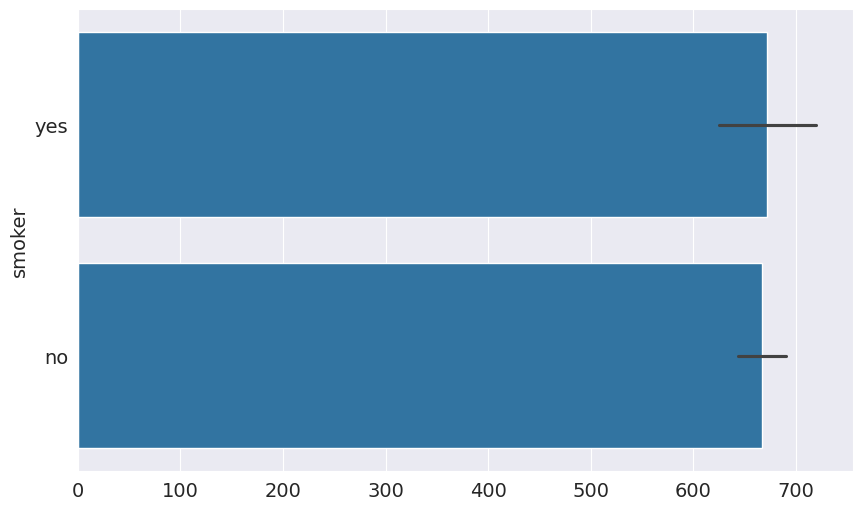

In [ ]:
sns.barplot(medical_df['smoker']);

### Висновки з діаграм:

#### 1. Діаграма "Children vs. Charges":
- **Висновок**: Незалежно від кількості дітей, медичні витрати (charges) демонструють схожий розподіл. Є кілька клієнтів з високими витратами незалежно від кількості дітей. Загалом, середнє значення витрат трохи підвищується з кількістю дітей, але варіативність залишається великою.

#### 2. Діаграма "Region vs. Charges":
- **Висновок**: Медичні витрати (charges) варіюються за регіонами, але в цілому розподіл виглядає схожим. Немає значної різниці між медичними витратами в різних регіонах. Однак, регіон Southeast має дещо більше клієнтів з високими витратами.

#### 3. Діаграма "Smoker vs. Non-Smoker Counts":
- **Висновок**: Кількість курців і некурців у наборі даних є досить збалансованою. Це свідчить про те, що куріння є важливим фактором, який необхідно враховувати при аналізі медичних витрат.

### Загальні висновки:
Ці діаграми допомагають зрозуміти вплив різних факторів (кількість дітей, регіон, куріння) на медичні витрати. Незважаючи на деякі відмінності, загальна варіативність медичних витрат залишається значною, що свідчить про складність та багатофакторність цього показника.

### Кореляція

Як ви можете бачити з аналізу, значення в деяких стовпцях більш тісно пов'язані зі значеннями в "charges" порівняно з іншими стовпцями. Наприклад, "age" та "charges" здається ростуть разом, тоді як "bmi" та "charges" - ні.

Цей зв'язок часто виражається числово за допомогою міри, яка називається _коефіцієнтом кореляції_, який можна обчислити за допомогою методу `.corr` серії Pandas.

In [ ]:
medical_df.charges.corr(medical_df.age)

0.2990081933306476

In [ ]:
medical_df.charges.corr(medical_df.bmi)

0.19834096883362895

Щоб обчислити кореляцію для категоріальних стовпців, їх спочатку потрібно перетворити на числові стовпці.

In [ ]:
smoker_values = {'no': 0, 'yes': 1}
smoker_numeric = medical_df.smoker.map(smoker_values)
medical_df.charges.corr(smoker_numeric)

0.787251430498478

Ось як можна інтерпретувати коефіцієнти кореляції ([джерело](https://statisticsbyjim.com/basics/correlations)):

* **Сила**: Чим більше абсолютне значення коефіцієнта кореляції, тим сильніше відношення.

    * Крайні значення -1 та 1 вказують на ідеально лінійне відношення, коли зміна однієї змінної супроводжується абсолютно стабільною зміною іншої. Для цих відношень усі точки даних розташовані на лінії. На практиці ви не побачите жодного типу ідеального відношення.

    * Коефіцієнт нуля представляє відсутність лінійного відношення. Коли одна змінна збільшується, інша змінна не має тенденції збільшуватися або зменшуватися.
    
    * Коли значення знаходиться між 0 та +1/-1, існує відношення, але точки не всі розташовані на лінії. Як r наближається до -1 або 1, сила відношення збільшується, і точки даних схильні розташовуватися ближче до лінії.


* **Напрямок**: Знак коефіцієнта кореляції представляє напрямок відношення.

    * Позитивні коефіцієнти вказують на те, що коли значення однієї змінної збільшується, значення іншої змінної також має тенденцію збільшуватися. Позитивні відношення створюють підйомний нахил на діаграмі розсіювання.
    
    * Негативні коефіцієнти представляють випадки, коли при збільшенні значення однієї змінної, значення іншої змінної має тенденцію зменшуватися. Негативні відношення створюють спадний нахил.

Ось таке ж відношення, виражене візуально ([джерело](https://www.cuemath.com/data/how-to-calculate-correlation-coefficient/)):

<img src="https://i.imgur.com/3XUpDlw.png" width="360">

Коефіцієнт кореляції має наступну формулу:

<img src="https://i.imgur.com/unapugP.png" width="360">

Ви можете дізнатися більше про математичне визначення та геометричну інтерпретацію кореляції тут: https://www.youtube.com/watch?v=xZ_z8KWkhXE

Pandas dataframes також надає метод `.corr` для обчислення коефіцієнтів кореляції між усіма парами числових стовпців.

In [ ]:
medical_df.corr(numeric_only=True)

,age,bmi,children,charges
age,1.000000,0.109272,0.042469,0.299008
bmi,0.109272,1.000000,0.012759,0.198341
children,0.042469,0.012759,1.000000,0.067998
charges,0.299008,0.198341,0.067998,1.000000


Результат `.corr` називається матрицею кореляції і часто візуалізується за допомогою теплової карти.

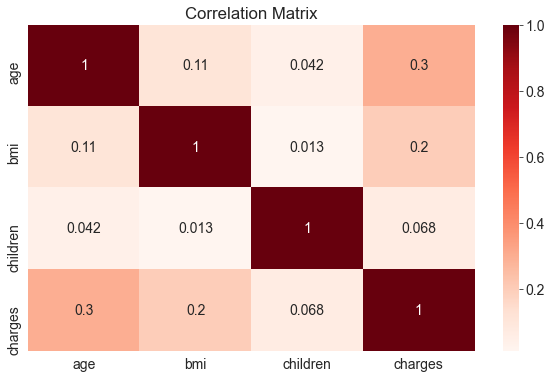

In [ ]:
sns.heatmap(medical_df.corr(numeric_only=True), cmap='Reds', annot=True)
plt.title('Correlation Matrix');

**Correlation vs Causality:** Зверніть увагу, що висока кореляція не може бути використана для інтерпретації причинно-наслідкового зв'язку між характеристиками. Дві характеристики $X$ та $Y$ можуть бути корельовані, якщо $X$ спричиняє $Y$ або якщо $Y$ спричиняє $X$, або якщо обидва незалежно спричинені якимось іншим фактором $Z$, і кореляція більше не буде вірною, якщо один з причинно-наслідкових зв'язків порушено. Також можливо, що $X$ та $Y$ просто здаються корельованими, тому що вибірка занадто мала.

Хоча це може здатися очевидним, комп'ютери не можуть відрізнити кореляцію від причинності, і рішення, прийняті на основі автоматизованої системи, часто можуть мати великі наслідки для суспільства, тому важливо вивчати, чому автоматизовані системи призводять до певного результату. Визначення причинно-наслідкових зв'язків вимагає людського розуміння.